# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_basic
from deepymod_torch.utilities import create_deriv_data

# Setting cuda if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

Next, we prepare the dataset.

In [5]:
data = np.load('data/burgers.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (256, 101)


Let's plot it to get an idea of the data:

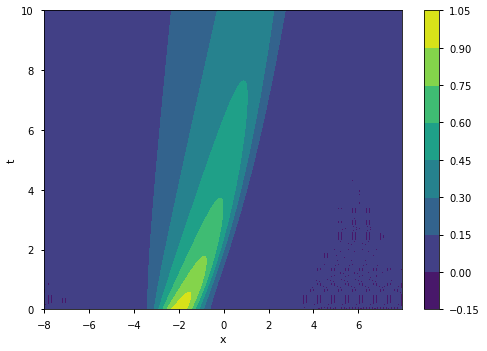

In [6]:
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [7]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))

print(X.shape, y.shape)

(25856, 2) (25856, 1)


In [8]:
X

array([[ 0.    , -8.    ],
       [ 0.1   , -8.    ],
       [ 0.2   , -8.    ],
       ...,
       [ 9.8   ,  7.9375],
       [ 9.9   ,  7.9375],
       [10.    ,  7.9375]])

As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [9]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [10]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [11]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

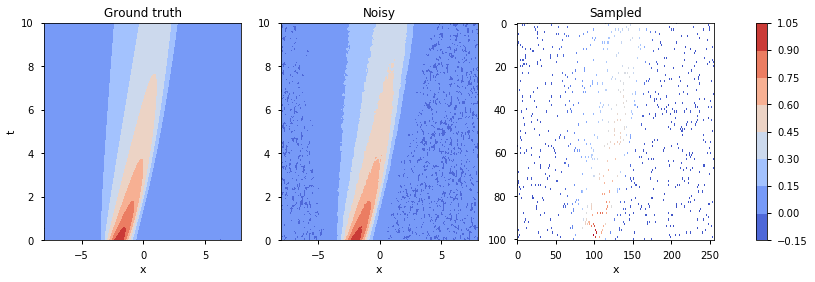

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [13]:
config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1, 'library_function': library_basic, 'library_args':{'poly_order': 2, 'diff_order': 2}}

Now we instantiate the model:

In [14]:
model = DeepMod(config)

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [16]:
model.train(X_input, y_train, optimizer, 5000, type='deepmod')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   9.38e-05   7.68e-05   2.42e-06   1.46e-05 
[Parameter containing:
tensor([[ 0.0952],
        [-0.9262]], requires_grad=True)]
[tensor([2, 4])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.13e-04   7.68e-05   3.57e-05   0.00e+00 

Now that DeepMoD has converged, it has found the following equation:

In [21]:
print('Final result:')
print(model.coeff_vector_list[0], model.sparsity_mask_list)

Final result:
Parameter containing:
tensor([[ 0.0952],
        [-0.9262]], requires_grad=True) [tensor([2, 4])]


# Other options

We have a few other options, most notably training the mse or a single deepmod cycle (i.e. mse + reg + l1, but not thresholding):

In [22]:
model.train(X_input, y_train, optimizer, 1000, type='mse')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       1000    100.00%               0s   7.68e-05   7.68e-05   0.00e+00   0.00e+00 

In [23]:
model.train(X_input, y_train, optimizer, 1000, type='single_cycle')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       1000    100.00%               0s   1.26e-04   7.68e-05   3.57e-05   1.35e-05 